In [1]:
import numpy as np
import pyuvdata
import matplotlib
import matplotlib.pyplot as plt
import os
import importlib

importlib.reload(pyuvdata)
from IPython.display import Image
from newcal import (
    caldata,
    calibration_wrappers,
    calibration_optimization,
    cost_function_calculations,
)

In [2]:
abscal_params = np.load("/safepool/rbyrne/hera_abscal_Jul2024/abscal_params.npy")
dwabscal_params = np.load("/safepool/rbyrne/hera_abscal_Jul2024/dwabscal_params.npy")

In [9]:
print(np.shape(abscal_params))

(3, 1536, 1)


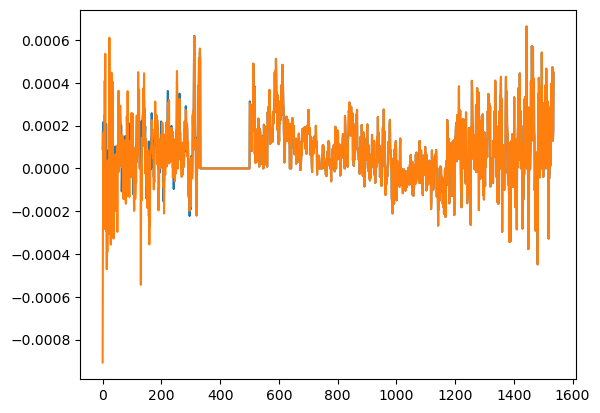

In [8]:
plt.plot(abscal_params[2, :, 0])
plt.plot(dwabscal_params[2, :, 0])
# plt.ylim([0,1.3])
plt.show()